# Gaussian Process for Time Series Forecasting

In [42]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
np.random.seed(1)

### Generate data

In [67]:
n = 100

X = np.linspace(0,100, n)
y = np.sin(X) + 0.2*X*X + np.random.normal(0,0.1, n)

# Train/val/test split
train_rows = int(len(X)*0.7)
val_rows = train_rows + int(len(X)*0.2)

X_train = X[:train_rows].reshape((-1,1))
X_val = X[train_rows:val_rows].reshape((-1,1))
X_test = X[val_rows:].reshape((-1,1))

y_train = y[:train_rows]
y_val = y[train_rows:val_rows]
y_test = y[val_rows:]

Text(0, 0.5, 'Value')

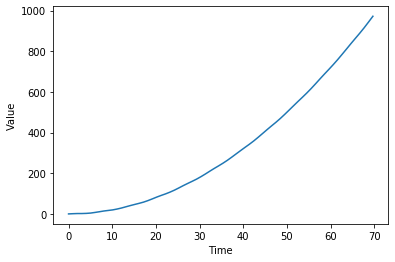

In [68]:
plt.plot(X_train, y_train)
plt.xlabel("Time")
plt.ylabel("Value")

### Covariance function
Most of the work involved in a Gaussian process lays within choosing a good covariance/kernel function. A periodic exponential sine squared component is good for modelling periodicity.

In [74]:
kernel = (ConstantKernel(5) 
          + 2 * RBF(5) 
          + ExpSineSquared(length_scale=3.0, periodicity_bounds=(1e-2, 1e2)) 
          + WhiteKernel(1))

### Train and visualise results
We use the validation data to inform our kernel/hyperparameter decisions. Once we are satisfied, we can evaluate the final model on the test data. The test data is *not* to be used for parameter optimisation!

In [75]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X_train, y_train)

y_pred, sigma = gp.predict(X_val, return_std=True)
y_pred_train, sigma_train = gp.predict(X_train, return_std=True)

Validation RMSE: 23.36861588389139
Validation PRMSE: 0.03790896359390699


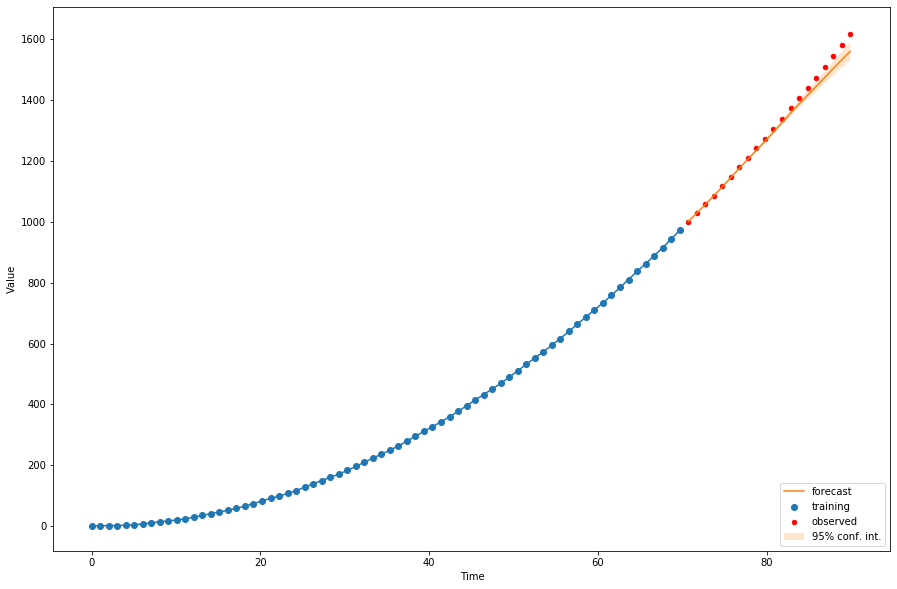

In [78]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE: {}".format(rmse))
print("Validation PRMSE: {}".format(rmse/(np.max(y_val)-np.min(y_val))))

# Plot the function, the prediction and the 95% confidence interval.
plt.figure(figsize=(15,10))
plt.scatter(X_train, y_train, label = "training")
plt.plot(X_train, y_pred_train)
plt.plot(X_val, y_pred, label = "forecast")
plt.scatter(X_val, y_val, label = "observed", c = 'red', alpha = 0.99, s = 20)
plt.fill_between(X_val.reshape(-1), y_pred - 1.97 * sigma, y_pred + 1.97 * sigma, alpha = 0.2, label = "95% conf. int.")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='lower right')

### Evaluate on test set
We need to merge the training and validation data, retrain the model and then make our forecast.

In [79]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

y_pred, sigma = gp.predict(X_test, return_std=True)

Test RMSE: 9.597579855114414
Test PRMSE: 4.798789927557207


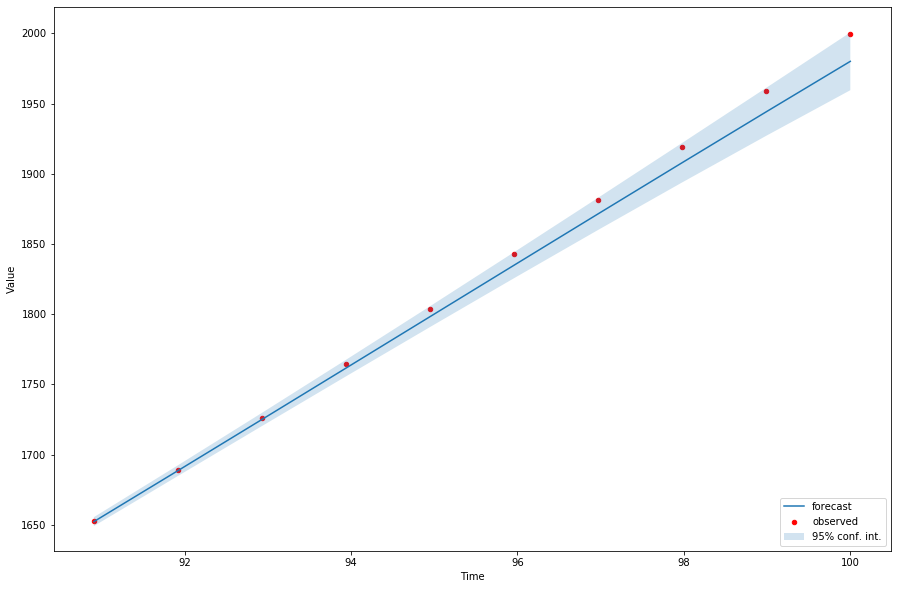

In [81]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: {}".format(rmse))
print("Test PRMSE: {}".format(rmse/2))

# Plot the function, the prediction and the 95% confidence interval.
plt.figure(figsize=(15,10))
plt.plot(X_test, y_pred, label = "forecast")
plt.scatter(X_test, y_test, label = "observed", c = 'red', alpha = 0.99, s = 20)
plt.fill_between(X_test.reshape(-1), y_pred - 1.97 * sigma, y_pred + 1.97 * sigma, alpha = 0.2, label = "95% conf. int.")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='lower right')